<h1>MUFG Data Science Basic Camp 2024 チュートリアル</h1>
<p>
MUFG Data Science Basic Camp 2024へようこそ!<br>
このチュートリアルでは、ある金融機関が保有するローン契約者データ（信用情報や過去の返済情報など）を元に、ローン完済ができないかどうかの予測を行います。<br>
このチュートリアルでは、予測アルゴリズムの作成を<a href="https://colab.research.google.com/">Google Colaboratory（以降、Colab）</a>上で実装し、提出ファイルを作成するところまでを説明します。<br>
Colabは、ブラウザ上でpythonによるプログラミングができる無料のサービスで、利用にはgoogleアカウントが必要です。<br>
</p>
<p>
チュートリアル終了後も、このコードをベースに精度を改善してみてください。<br>
またこのチュートリアルで使用するNotebookは、「データ」ページからダウンロード可能です。<br>
たくさんの投稿を心よりお待ちしております！
</p>

<h2>目次</h2>

1. Colabの使用方法
2. ライブラリの読み込み
3. データの読み込み
4. 探索的データ分析（EDA）
5. 学習・検証
6. 予測・結果の提出
7. 精度改善のヒント

<h2>1.Colabの使用方法</h2>
<p>以下では、Colabの起動からGoogle Drive内のデータ読み込むための準備の手順を説明します。</p>

<h3>Colabの起動</h3>

1. Googleアカウントにログイン
2. ブラウザで <a href="https://colab.research.google.com/">Colab</a> にアクセス
3. 「新しいノートブック」をクリックして、新しいColab環境を立ち上げる

<h3>Google Driveのディレクトリ構成</h3>
<p>
Colabで作成したノートブックは自動的にマイドライブの中の「Colab Notebooks」フォルダに保存されます。<br>
今回はマイドライブの中に、以下のような構造でデータを置くことを前提とします。
</p>

```sh
マイドライブ/
├── Colab Notebooks/
│   └── tutorial.ipynb
├── data/
│   ├── train.csv
│   ├── test.csv
│   └── sample_submission.csv
```

<h3>Google Driveへの接続方法</h3>

1. Colabノートブックを開いた状態で、以下のコードを実行して自分のGoogle Driveへ接続

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

2. 「Google Driveに接続」をクリックし、Googleアカウントを選択
3. 接続が成功すると、「Mounted at /content/drive」というメッセージが表示される
<p>
これで、自分のGoogle Drive に接続できました!<br>
以下のコードでマイドライブの中にあるフォルダを確認することもできます。
</p>

In [ ]:
ls /content/drive/MyDrive

<h2>2.ライブラリの読み込み</h2>

ライブラリを読み込むことで、pythonがある特定の分野に特化した処理を行うことができるようになります。<br>
データ分析を行うためのライブラリを読み込みましょう。<br>

In [ ]:
!pip install japanize_matplotlib  # Colab環境にjapanize_matplotlibをインストール
# その他のライブラリは、Colabではデフォルトで利用可能

import pandas as pd               # データを表のように扱うライブラリ
import numpy as np                # 数値計算を速くするライブラリ
import seaborn as sns             # きれいなグラフを簡単に作るライブラリ
import matplotlib.pyplot as plt   # グラフを作る基本的なライブラリ
%matplotlib inline
import japanize_matplotlib        # グラフに日本語を表示するライブラリ
japanize_matplotlib.japanize()

from sklearn.model_selection import train_test_split  # データを学習用とテスト用に分ける
from sklearn.linear_model import LogisticRegression  # LogisticRegressionという手法でモデル学習を行うライブラリ
from sklearn.metrics import roc_auc_score, confusion_matrix  # 評価の計算を行うライブラリ
from sklearn.preprocessing import StandardScaler  # 標準化の計算を行うライブラリ

import warnings
warnings.simplefilter('ignore')  # 不要な警告を表示しない設定（マストではないが見やすいコードのために、よく設定されるもの）

<h2>3.データの読み込み</h2>

<p>それではデータを読み込んでみましょう。<br>
データを読み込むには pd.read_csv() を使います。<br>
マイドライブは/content/drive/の中にあるので、trainデータまでのパスは以下のようになります。</p>

In [15]:
train = pd.read_csv('/content/drive/MyDrive/data/train.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/data/test.csv', index_col=0)

In [16]:
train.head()

,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,NaN,0.1691,652.10,29579.74,10.66,730,3333,4955.0,39.6,4,2,0,1
1,major_purchase,0.1354,191.27,52808.95,13.06,707,6063,12335.0,37.8,2,1,0,0
2,credit_card,0.0758,377.00,168689.22,11.98,736,2681,1505.0,5.0,1,0,0,0
3,debt_consolidation,0.1774,359.33,71325.19,20.55,702,3972,39536.0,94.1,1,0,0,0
4,credit_card,0.1430,875.45,130773.88,17.61,688,5555,17295.0,56.4,0,0,0,0


In [17]:
test.head()

,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
40785,debt_consolidation,0.1543,225.68,16525.86,22.39,668,1960,43771.0,59.3,3,0,0
40786,debt_consolidation,0.1539,200.43,62412.73,21.84,660,5958,13607.0,87.0,1,1,0
40787,debt_consolidation,0.1503,252.35,42836.79,21.77,663,4950,1832.0,36.8,5,0,1
40788,debt_consolidation,0.1316,533.85,27821.44,10.60,690,1825,3597.0,60.0,0,0,0
40789,debt_consolidation,0.1506,484.50,91406.09,17.35,658,3253,12137.0,48.8,1,0,0


<p>
それぞれの特徴量の意味はデータタブで説明していますので確認してください。<br>
次にデータ型とデータのサイズをみてみましょう。
</p>

In [22]:
print('train shape', train.shape)
train.info()

train shape (40785, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 40785 entries, 0 to 40784
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purpose            40012 non-null  object 
 1   int.rate           40785 non-null  float64
 2   installment        40779 non-null  float64
 3   annual.inc         40785 non-null  float64
 4   dti                40785 non-null  float64
 5   fico               40785 non-null  int64  
 6   days.with.cr.line  40785 non-null  int64  
 7   revol.bal          40784 non-null  float64
 8   revol.util         40773 non-null  float64
 9   inq.last.6mths     40785 non-null  int64  
 10  delinq.2yrs        40785 non-null  int64  
 11  pub.rec            40785 non-null  int64  
 12  not.fully.paid     40785 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 4.4+ MB


In [23]:
print('test shape', test.shape)
test.info()

test shape (40786, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 40786 entries, 40785 to 81570
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purpose            40282 non-null  object 
 1   int.rate           40786 non-null  float64
 2   installment        40782 non-null  float64
 3   annual.inc         40786 non-null  float64
 4   dti                40786 non-null  float64
 5   fico               40786 non-null  int64  
 6   days.with.cr.line  40786 non-null  int64  
 7   revol.bal          40780 non-null  float64
 8   revol.util         40769 non-null  float64
 9   inq.last.6mths     40786 non-null  int64  
 10  delinq.2yrs        40786 non-null  int64  
 11  pub.rec            40786 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 4.0+ MB


<p>purposeは文字列、それ以外は数字を表す特徴量（int, float）であることがわかりました。<br>
次に欠損値を確認しましょう。</p>

In [24]:
train.isnull().sum()

purpose              773
int.rate               0
installment            6
annual.inc             0
dti                    0
fico                   0
days.with.cr.line      0
revol.bal              1
revol.util            12
inq.last.6mths         0
delinq.2yrs            0
pub.rec                0
not.fully.paid         0
dtype: int64

In [25]:
test.isnull().sum()

purpose              504
int.rate               0
installment            4
annual.inc             0
dti                    0
fico                   0
days.with.cr.line      0
revol.bal              6
revol.util            17
inq.last.6mths         0
delinq.2yrs            0
pub.rec                0
dtype: int64

<p>train, testの共通した特徴量に欠損値があることが確認できました。</p>

<h2>4.探索的データ分析(EDA)</h2>
<p>
それでは次に探索的データ分析を行います。<br>
探索的データ分析をすることで、データがどのような特徴を持っているのか、どのような特徴量が目的変数の予測に重要なのかを知ることができます。<br>
まずは統計量を見てみましょう。
</p>


In [26]:
train.describe()

,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,40785.000000,40779.000000,4.078500e+04,40785.000000,40785.000000,40785.000000,40784.000000,40773.000000,40785.000000,40785.000000,40785.000000,40785.000000
mean,0.125414,302.329408,7.087001e+04,12.530579,709.393061,4736.481746,15426.217953,46.170792,1.543018,0.180998,0.039696,0.151870
std,0.030167,208.068861,6.524275e+04,6.831929,39.299297,2568.216636,22343.735674,28.257963,2.059082,0.513544,0.195246,0.358899
min,0.060800,15.680000,2.086720e+03,0.110000,615.000000,179.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,0.105300,157.400000,3.868640e+04,6.700000,679.000000,2965.000000,3433.000000,22.600000,0.000000,0.000000,0.000000,0.000000
50%,0.125200,241.140000,5.862029e+04,12.740000,703.000000,4304.000000,8441.000000,44.500000,1.000000,0.000000,0.000000,0.000000
75%,0.145100,391.995000,8.416863e+04,17.930000,737.000000,5896.000000,19085.500000,68.900000,2.000000,0.000000,0.000000,0.000000
max,0.800000,939.380000,1.913363e+06,29.930000,826.000000,16888.000000,356328.000000,108.300000,14.000000,3.000000,1.000000,1.000000


In [27]:
test.describe()

,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
count,40786.00000,40782.000000,4.078600e+04,40786.000000,40786.000000,40786.000000,40780.000000,40769.000000,40786.00000,40786.000000,40786.000000
mean,0.12544,300.582001,7.019006e+04,12.552485,709.242338,4685.578556,15249.915571,46.423736,1.52876,0.179694,0.038739
std,0.03087,208.178433,6.145846e+04,6.836684,39.320390,2540.021093,22273.623474,28.320324,2.08263,0.513398,0.192974
min,0.06160,15.680000,2.128340e+03,0.090000,616.000000,181.000000,1.000000,0.100000,0.00000,0.000000,0.000000
25%,0.10540,155.790000,3.855412e+04,6.700000,679.000000,2928.250000,3367.000000,23.000000,0.00000,0.000000,0.000000
50%,0.12510,240.410000,5.814888e+04,12.760000,704.000000,4253.000000,8258.000000,44.700000,1.00000,0.000000,0.000000
75%,0.14510,388.420000,8.379708e+04,17.950000,736.750000,5834.000000,18688.250000,69.100000,2.00000,0.000000,0.000000
max,0.90000,938.860000,2.000790e+06,29.950000,826.000000,17416.000000,296156.000000,109.600000,14.00000,3.000000,1.000000


<p>
それぞれの特徴量の基本統計量を表示できました。<br>

</p>

<p>それぞれの特徴量の意味と、この統計量を見て、どんな人がローンを返済できないのかを想像してみましょう。</p>

- 目的変数（not.fully.paid）の平均値が約0.15であることから返済できない人が15%ほどの不均衡なデータである
- 利率（int.rate）や月々の返済額（installment）の最小値と最大値では大きな差があり、これらの数値が高い場合、未返済のリスクが高くなるのではないか
- 年収（annual.inc）が高いのは収入が多いことを意味するので、ローンの返済能力も高いのではないか
- FICOスコア（fico）が高いほど信用力が高いことを意味するのでローンの返済能力も高いのではないか

可視化して確認してみましょう。

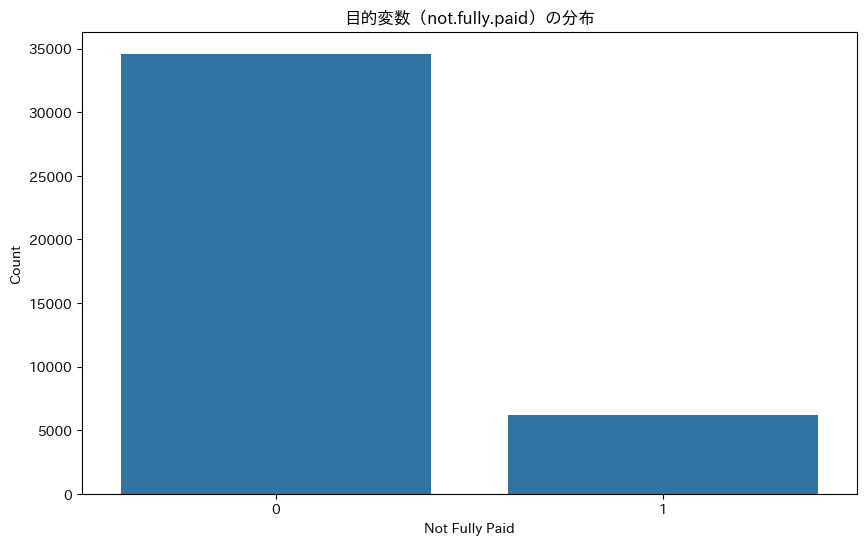

In [28]:
# 目的変数の分布
plt.figure(figsize=(10, 6))
sns.countplot(x='not.fully.paid', data=train)
plt.title('目的変数（not.fully.paid）の分布')
plt.xlabel('Not Fully Paid')
plt.ylabel('Count')
plt.show()

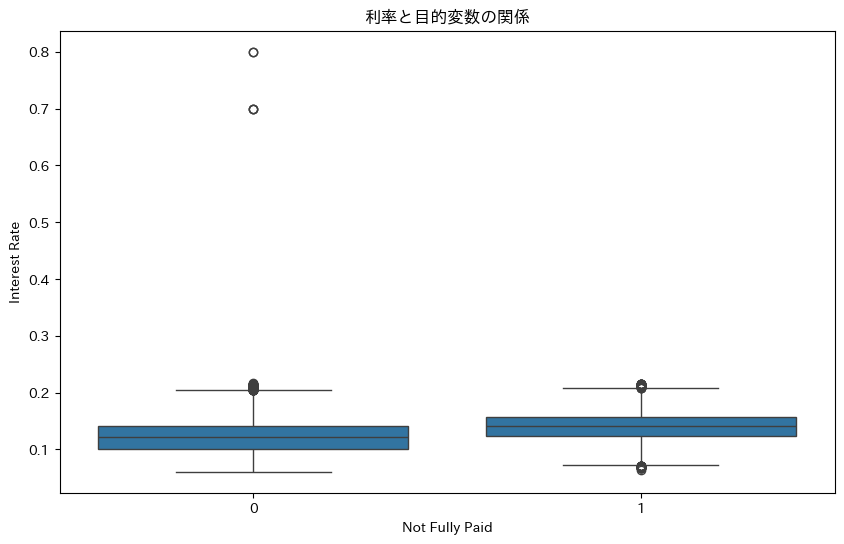

In [29]:
# 仮説1: 高い利率はローン未返済のリスクを増加させる
plt.figure(figsize=(10, 6))
sns.boxplot(x='not.fully.paid', y='int.rate', data=train)
plt.title('利率と目的変数の関係')
plt.xlabel('Not Fully Paid')
plt.ylabel('Interest Rate')
plt.show()

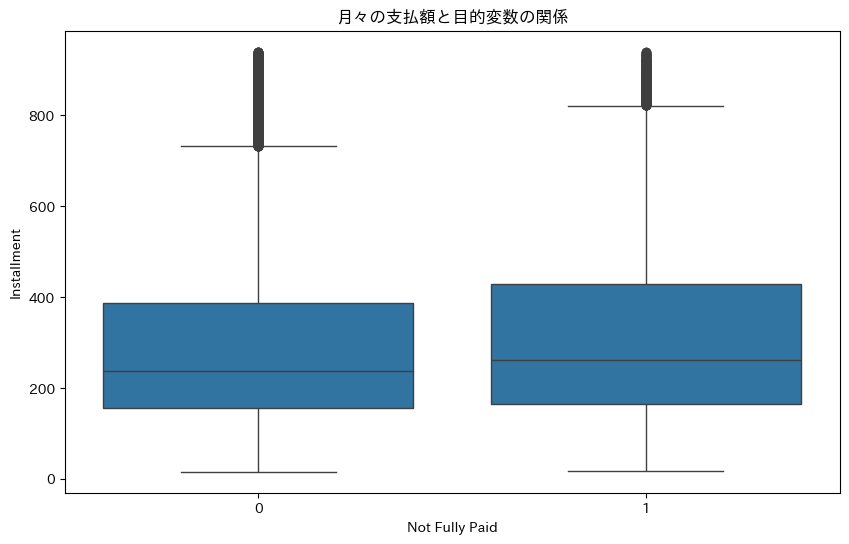

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='not.fully.paid', y='installment', data=train)
plt.title('月々の支払額と目的変数の関係')
plt.xlabel('Not Fully Paid')
plt.ylabel('Installment')
plt.show()

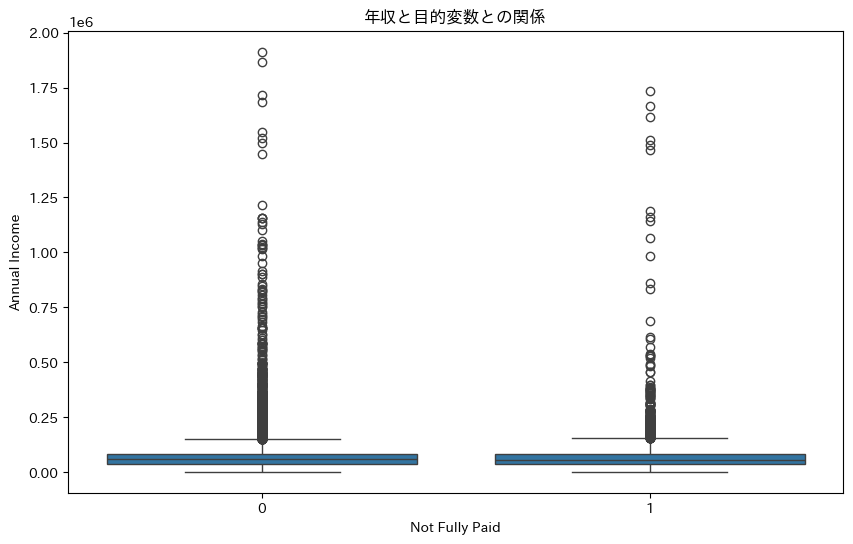

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='not.fully.paid', y='annual.inc', data=train)
plt.title('年収と目的変数との関係')
plt.xlabel('Not Fully Paid')
plt.ylabel('Annual Income')
plt.show()

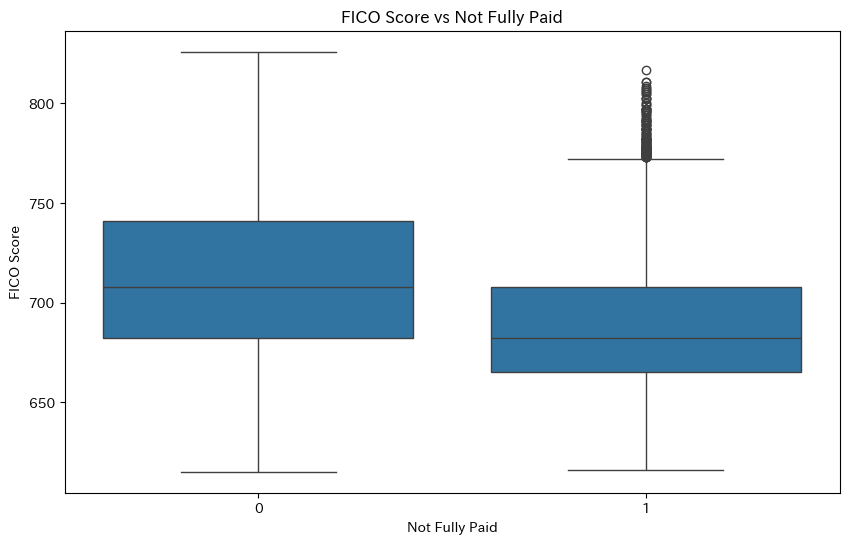

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='not.fully.paid', y='fico', data=train)
plt.title('FICO Score vs Not Fully Paid')
plt.xlabel('Not Fully Paid')
plt.ylabel('FICO Score')
plt.show()

可視化の結果、利率（int.rate）やFICOスコア（fico）は想像通りでしたが、年収（annual.inc）や月々の支払額（installment）は直接目的変数に関係していなさそうに見えます。<br>
相関も見てみましょう。

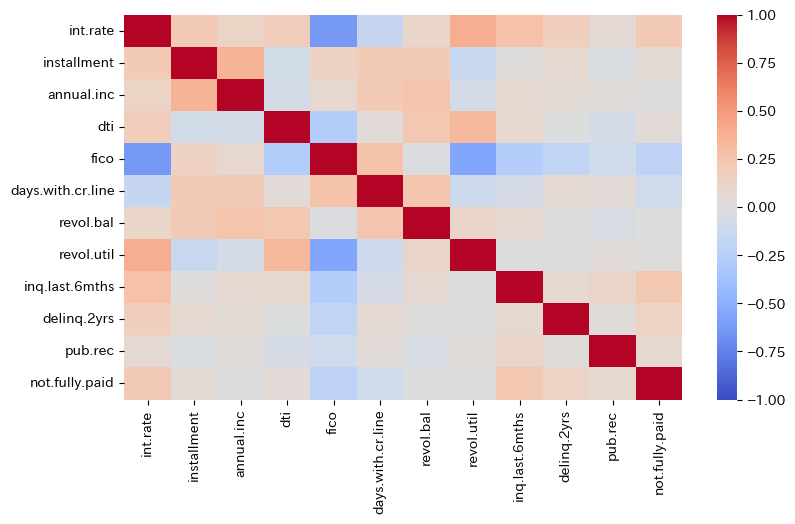

In [34]:
plt.figure(figsize=(9, 5))
sns.heatmap(train.select_dtypes(include=['int64', 'float64']).corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

想像した特徴量の他に過去6ヶ月間のクレジット照会件数（inq.last.6mths）と目的変数の相関が高いことがわかりました。

<h2>学習・検証</h2>
<p>ここまでの結果から、以下の特徴量を使って学習を行います。</p>

- int.rate
- annual.inc
- fico
- inq.last.6mths

In [35]:
selected_features = ['int.rate', 'annual.inc', 'fico', 'inq.last.6mths']
X = train[selected_features]
y = train['not.fully.paid']
X_test = test[selected_features]

In [36]:
X.head()

,int.rate,annual.inc,fico,inq.last.6mths
0,0.1691,29579.74,730,4
1,0.1354,52808.95,707,2
2,0.0758,168689.22,736,1
3,0.1774,71325.19,702,1
4,0.1430,130773.88,688,0


Xを見ると数値の範囲が特徴量ごとに大きく異なることがわかります。<br>
このように数値そのものが大きすぎたり、数値の範囲が異なると一部の機械学習アルゴリズムは不都合を起こす可能性があります。<br>
この場合、数値を変換する必要があります。特にある数値の範囲を別の範囲に変換することをスケーリングといいます。<br>
スケーリングする変更する有名な方法は以下の2つがあります。

- 正規化
- 標準化

本チュートリアルでは標準化を用いて変換を行います。<br>
標準化とは変換前量的変数の平均と標準偏差を使用し、変換後量的変数の平均が0、分散が1になるように変換する方法です（標準偏差は分散の平方根）。

それではやってみましょう。

In [37]:
ss = StandardScaler()
X_ss = pd.DataFrame(ss.fit_transform(X), columns=X.columns)
X_test_ss = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

In [38]:
X_ss.head()

,int.rate,annual.inc,fico,inq.last.6mths
0,1.448186,-0.632879,0.524365,1.193256
1,0.331043,-0.276832,-0.060894,0.221937
2,-1.644678,1.499330,0.677042,-0.263722
3,1.723329,0.006977,-0.188124,-0.263722
4,0.582980,0.918180,-0.544369,-0.749381


それではAIの学習を行ってみましょう。<br>
まず、データの分割を行います。データの分割は、学習するモデルの性能を適切に計測することができる効果があり、実用化する際の機械学習の性能を担保するためには重要な作業となります。<br>
本チュートリアルではtrain_test_splitでやってみましょう。<br>

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_ss, y, test_size=0.25, random_state=82, stratify=y) #stratifyをyにして層化を行う

In [40]:
print("分割前", X_ss.shape)
print("分割後", X_train.shape, X_valid.shape)

分割前 (40785, 4)
分割後 (30588, 4) (10197, 4)


shapeを確認することでデータが分割されたことがわかります。<br>
またtrain_test_splitのパラメータとしてstratify=yを指定しています。これは、目的変数（not.fully.paid）の割合が変わらないように分割するコードになります。<br>
今回のような不均衡な場合は特にですが、目的変数の分布はモデルの精度に大きく影響する場合がありますので注意してください。<br>
<br>
それでは機械学習アルゴリズムの学習を行ってみましょう。<br>
今回は不均衡データにも対応しやすいロジスティック回帰を使用します。<br>
scikit-learnからimportして使用するロジスティック回帰には、不均衡を考慮して学習できるclass_weightというパラメータが利用可能です。

In [41]:
lr = LogisticRegression(random_state=82, class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=82)

モデルの学習が完了しました。<br>
あらかじめ分けておいたvalidデータで学習したモデルの性能を確認しましょう。<br>
本コンペティションで使用する評価指標はAUCになりますのでscikit-learnからroc_auc_scoreを呼び出して評価します。<br>

In [42]:
train_pred = lr.predict_proba(X_train)[:, 1]
valid_pred = lr.predict_proba(X_valid)[:, 1]
print('train score : ', roc_auc_score(y_train, train_pred))
print('valid score : ', roc_auc_score(y_valid, valid_pred))

train score :  0.7266567132954846
valid score :  0.716907718207981


モデルの性能の評価が完了しました。<br>
lr.predict_proba(X_train)というコードは各行に対して[クラス0の確率, クラス1の確率]という形で出力します。<br>
なので[:, 1]この部分で、それぞれの確率のうち、クラス1（ローンが返済できない）の確率だけを選択し、予測結果としています。

<h2>予測・結果の提出</h2>
最後に学習したモデルをテストデータに対して予測をし提出を行います。

In [43]:
test_pred = lr.predict_proba(X_test_ss)[:, 1]

それでは提出ファイルを作成します。<br>
提出ファイルの見本はsample_submission.csvにあります。また、to_csv()でデータをcsvとして保存することができます。<br>
ではこのデータをcsv形式で保存し提出しましょう。

In [46]:
submit = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv', header=None)
submit[1] = test_pred
submit.to_csv('/content/drive/MyDrive/data/submission_tutorial.csv', header=None, index=False)

In [45]:
submit.head()

,0,1
0,40785,0.700199
1,40786,0.619487
2,40787,0.771234
3,40788,0.438287
4,40789,0.608310


これで本チュートリアルは終了です。<br>
早速作成したsubmission_tutorial.csvを早速提出してみましょう。<br>
コンペサイトの投稿ボタンから提出可能です。

<h2>精度改善のヒント</h2>
<p>提出が完了したところでこのコンペティションは終わりではありません。次に精度を改善する必要があります。<br>
ですがどうすれば精度を上げられるでしょうか?下記にヒントを掲載します。</p>

- 前処理を行いましょう。確認した欠損値や外れ値の処理を行うことで、モデルの精度が向上する可能性があります。
- まだまだ利用していない特徴量があります。selected_columnsに新たな特徴量を入れてみましょう。
  - 特徴量を複数使って新たな特徴量を作成することも可能です。
- LogisticRegression以外にも様々な特徴を持つ学習アルゴリズムがあります。様々な学習アルゴリズムを使ってみましょう。
- 不均衡データのへの対応方法としてデータを水増しするなどの様々な方法があります。さまざまな不均衡データの対応を調査して実装してみましょう。